
# CS342 Coursework

Christos Demetriou 2018918

// Comment: the images for the markdown sections were loaded from the current working directory, so they might not work if the markdown code is recompiled


In [1]:
# Library imports
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Data import initialization

Read data from data path.
Since the data have no headers, set header option to None to use first row as data.
In addition using `pd.Categorical(dataset[0]).codes` allows to convert the label data to categorical integer values. This would make it easier later on to manipulate the data and make measurements the accuracy of the perceptrons.

In [2]:
# Data
DATA_PATH = "cw.data"

colors = np.array([ # Map classes to colors
     'red',
     'blue',
     'green',
     'yellow',
     'brown',
     'purple',
])

# Dataset has no headers => therefore set the header flag to false
dataset = pd.read_csv(DATA_PATH,header=None)
# Convert data to Categorical integer values
dataset[0] = pd.Categorical(dataset[0]).codes
# Convert pandas dataframe to numpy
dataset = dataset.to_numpy()
# Extract labels and examples
y,Xnp = dataset[:,0].astype('byte'), dataset[:,1:]

## Part I - Visually determine Linear Separability 

To do that we are going to use PCA decomposition.
PCA decomposition is a method used to map high-dimensional data to lower dimensions. In this case we are planning to use it in order to
map the original feature space to two dimensions and visually determine if we can linearly separate the data. By linear separation it implies we can divide the feature space to multiple disjoint sub spaces using straight lines such that the area enclosed between the lines contains data from a specific label only.
To achieve that we center the data, then using SVD (Singular Value Decomposition) return the top PCA matrix. 

In [3]:
def PCA_decomp(X,m,k=None):
    '''
        X : np.array, Data to decompose
        m : np.array, mean of training data
        k : Optional[int]
        returns eigenvector matrix with the top k components
    '''
    X_center = X - m  # Center Data
    _,_,V = np.linalg.svd(X_center,full_matrices = True) # apply SVD decomposition
    if k == None: # if we haven't defined the number of top components
        return V # return the full matrix
    else:
        return V[0:k] # return the top k

### Determining linear separability
Using PCA we map the 12 dimensional feature space to 2 dimensions, using the top 2 principal components. Then we construct the weight matrix that contains factors for the PCAs. To do that we can apply the following deduction:

$$
X = ZV^T \leftrightarrow X(V^T)^{-1} = Z(V^T)(V^T)^{-1}
\\
\leftrightarrow  X (V^T)^{-1} = ZI = Z 
$$
But we know the the PCA matrix is orthogonal, therefore : 
$$
X(V^T)^T = Z \leftrightarrow XV=Z 
$$
Therefore we multiply the training set with the PCA matrix in order to generate the factor matrix. Using the factor loadings of the first two PCAs, we use a scatter plot to plot them on a 2D space, and color each point according to its analogous label.


From the scatter plot shown below, we can deduce that there is no combination of 6 straight lines such that we can linearly seperate the feature space to their appropriate labels. This is mostly due to the clustering of data that occurs around the left side of the plot.

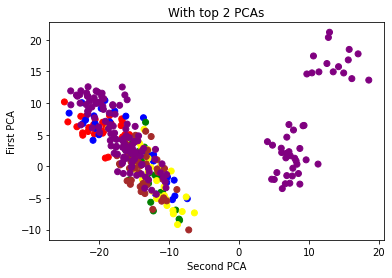

In [6]:
# Data to visualize
m = Xnp.mean(axis=0)
V = PCA_decomp(Xnp,m,None) # Return V transpose

Z = Xnp @ V.T # Multiply Xnp @ V.T = (V transpose).T = V (Therefore following the equation we derived above)

plt.scatter(Z[:,0],Z[:,1],color=colors[y])
plt.ylabel("First PCA")
plt.xlabel("Second PCA")

plt.title("With top 2 PCAs")
plt.show()

## Part 2 
Determining if data are linearly seperable using a multi-class perceptron

### Multi-Class Perceptron
To explain how the multi-class perceptron works it is best to show first how the binary classification perceptron works

#### Binary class perceptron
A perceptron essentially uses a weighted sum of a given example $x_i$ and classifies it using its sign. In more detail:
$$
\text{Given perceptron column vector } w  \text{ and training example $x_i$} \\
    \hat{y} = sign(w^{T} x_i)
$$
The key of the algorithm comes when determining the appropriate weights of the perceptron. The way it works is by 
"punishing" the perceptron for each wrong classification. This is done by adding to the perceptron $y_i * x_i$ where $y_i$ is the ground truth for example $x_i$. The reason why this works can be seen in:

![perceptron visualization](./assets/percept_equation.png "Perceptron equation")

By repeadly iterating through all the data, the algorithm can determine if they are linearly separable in a finite amount of iterations. 

#### Multi-Class Perceptron (MCP)

The multi-class perceptron is an extension of the traditional binary-class perceptron to multiple classes by using the "one for all" classification.
"One for all" turns multiple binary linear classifiers into multi-class classifiers. It works by the following logic:
Given MCP matrix $W$ where it contains $k$ linear classifiers  for an $n$-dimension feature space:
$$
W = \begin{bmatrix}
w_1^1 & w_1^2 & \dots & w_1^n  \\
\vdots & & & \vdots \\
w_c^1 & w_c^2 & \dots & w_c^n  \\
\vdots & & & \vdots \\
w_k^1 & w_k^2 & \dots & w_k^n  \\
\end{bmatrix}
$$
In which it classifies the data as follows, given training example $x_i$
$$
\hat{y_i} = \underset{c}{\operatorname{argmax}}(Wx_i)
$$
And for the entire training set X:
$$
\hat{y} = \underset{c}{\operatorname{argmax_{row}}}(XW) = 

\begin{bmatrix}
\underset{c}{\operatorname{argmax}}(Wx_1) \\
\underset{c}{\operatorname{argmax}}(Wx_2) \\
\vdots \\
\underset{c}{\operatorname{argmax}}(Wx_n) \\
\end{bmatrix}
$$
Training for such model works as follows, finitely iterate through the iterate training set. For each $x_i$
calculate $\hat{y_i} = \underset{c}{\operatorname{argmax}}(Wx_i) $, given its ground truth $y_i$
* If  $\hat{y_i} = y_i$, do nothing
* Else :
  * $ W[\hat{y_i}] \leftarrow W[\hat{y_i}] - x_i$ 
  * $ W[y_i] \leftarrow W[y_i] + x_i$ 

Essentially we are applying the same refinement process on the unrefined perceptrons. The ground truth of the correct binary classifier is $+1$ whereas for all the others it should be $-1$. Therefore refine the two perceptrons as needed.


Using this logic, we can use the perceptron to test if the data are linearly separable in the following spaces:

* Original feature space
* PCA defined featured space
* Kernel-PCA defined feature space




### Learning rate

The algorithm was tested with different learning rates. Below there are figures over different iterations of the perceptron algorithm's accuracy where the top graph indicates the average accuracy over different learning rates, whereas the bottom shows the variance:



| ![Average peak 0.4 ](assets/peak04.png) |
|:--:|
| <img src="assets/peak05.png" alt="Average peak 0.5" width="248" height="290" /> |
| ![Average peak 1. ](assets/peak1.png)  |
| <b>Average run over 200 iterations for different learning rates between  $0.1$ to $1.0$ using the original feature space</b>|

These statistics were taken from previous test runs on the original feature space. It is clearly shown that there is no consistent improvement with the usage of learning rates for two main reasons:

* range of the averages is on average $\sim 0.01$
* experiments show inconsistnent results

Therefore for the perceptrons there will be no learning rate, due to how low impact it has on the performance of the perceptron

In [5]:
# The perceptron function
def percept(X,v):
    """
    X : The training data
    v : Ground truth of the training data
    retruns Multi-class perceptron
    """
    W = np.zeros((6,X.shape[1])) # Multi-class perceptron
    MAX_ITER = 10 # Maximum number of iterations
    for _ in range(MAX_ITER):
        # Create a permuation of the list of numbers from 0 to the number of training samples
        # This is to ensure a random iteration over the training sample
        perms = np.random.permutation(X.shape[0]) 
        Xp = X[perms]
        vp = v[perms]
        cnt = 0
        # zip : function that takes a variable length of iterators/generators and returns
        # a generator that yields a tuple of the current items yielded from all the generators/iterators
        # It is very useful due to it being an idiomatic way to access multiple data structures at once
        # In addition it cuts down the cost of accessing
        for (xi,yi) in zip(Xp,vp):
            # Rows yielded from numpy 2D arrays of the from (n,)
            # These are one dimensional arrays but in order for them to be used in different manipulations such as
            # transpose and matrix multiplication, the array is being reshaped to (n,1)
            x = xi.reshape(X.shape[1],1) 
            # From the definition of "one vs all" mutli-class perceptron (MCP):
            # W @ x, calculates for each 
            # binary perceptron likelness of the specific training example being what it classifies
            # using `np.argmax`, we get the index c of the perceptron with the highest likelyhood
            # This also implies that the MCP predicts that the label of the current training example is
            # c.
            # This is also the reason why categorical encoding was used as labels
            ar_x = np.argmax(W @ x)
            # If the ground truth of the training example disagrees with the prediction of the MCP
            # Refine perceptron by punishing both perceptrons in fault. First add to the perceptron that
            # should have made the correct identification the training example, and subtract from the perceptron
            # xi from the missclassified perceptron. This ensures that correct classifier will make the right prediction
            if ar_x != yi:
                # count is being used to count the number of missidentifications
                cnt += 1
                W[yi,:] += xi.T
                W[ar_x,:] -= xi.T
        # If there were no miss identifications, break from iterations
        if cnt == 0:
            break
    # After the refinement of the MCP, return it
    return W

## Space 1: Using original feature space

In this part, we use MCP in order to find a linear separation of the training data. To achieve this, we take take the current training and then:
* First we add biases to all training examples, this is to improve the performance of the perceptron
* Second we run the multi-class perceptron algorithm on the biased training set
* Third, we use the formula mentioned previously to get the predicted values of the perceptron
* Last but not least, we compare the predicted values to the ground truth and return the accuracy of the perceptron

In [7]:
# Addition of bias to improve the accuracy of the perceptron
# np.insert takes : the matrix to make the insertion, the index in which to add the new value and along 
# which axis the new item should be added to
Xb = np.insert(Xnp,0,1.,axis=1)
# Create a MCA of the algorthm
W = percept(Xb,y)
# Xb @ W.T will create an n x k matrix where n is the number of training examples and k the number
# of perceptrons. Essentially in this step we are calculating the predictions for the entire training set
# To get the what the MCP predicted, run argmax on along the 1st axis. This will return a 1D array yhat
# for the predicted labels for each training example
# We can compare yhat to actual ground truth y by using the == operator
# This returns a boolean array
# We can then use np.unique. np.unique is often used to get the unique values of a matrix but by 
# enabling the return_counts flag, we can get the frequency of each unique value
# As a result np.unique a tuple of two values, the unique values which we ignore
# And the frequencies for each of the values
# Since we know the second index of the cnts table associates to the frequency of correct classifications
# We print out the accuracy of the MCP by `# of correct predictions / total number of samples`. Total number 
# of samples is calculate by summing both the true and false frequences
uniq,cnts = np.unique(np.argmax(Xb @ W.T,axis=1) == y,return_counts=True)
print(f"Accuracy of original feature space {cnts[1] / cnts.sum()}"  )

Accuracy of original feature space 0.6443768996960486


### Discussion in the linear separability of the original feature space

Running the algorithm over multiple iterations or even tuning the iterations of the perceptron it self to higher iterations showed inability find a perfect classifier and therefore a linear separation of data. In reality, the accuracy of the perceptron is usually between $45\% - 75\%$ and therefore we cannot find a linear separation of the data using the original feature space.

## Space 2 : Using Linear-PCAs

In this section, we are trying to determine if mapping the data lower dimensional spaces, makes the training sample linearly separable.

To achieve this, first we create a PCA decomposition of the training set. Then, we need to extract the factor matrix for the $V^T$. To create a linear model for the PCAs, we try to linearly separate the data using the factor loadings of the top PCAs. The reasoning is as follows:

In the original feature space the data can be thought of as follows
$$
x = \begin{bmatrix}
           x_{1} \\
           x_{2} \\
           \vdots \\
           x_{12}
         \end{bmatrix}
  = x_1 * \begin{bmatrix}
           1    \\
           0     \\
           \vdots \\
           0
         \end{bmatrix}
    + x_2 * \begin{bmatrix}
           0 \\
           1 \\
           \vdots \\
          0
         \end{bmatrix}
    + \dots
    + x_{12} * \begin{bmatrix}
           0 \\
           0 \\
           \vdots \\
          1
         \end{bmatrix}
$$

We can represent $k$-dimensonal spaces ($k \leq 12$) by using the top $k$ PCA as follows :
Since we know $X \approx ZV^T \implies$

$$
x = \begin{bmatrix}
           x_{1} \\
           x_{2} \\
           \vdots \\
           x_{12}
         \end{bmatrix}
  \approx z_1 * \text{PCA$^{1st}$ } + z_2 * \text{PCA$^{2nd}$ } + \dots + z_k* \text{PCA$^{kth}$ } 
$$

Based on this logic, since in the original space we also used the factors of the basis, we can construct the perceptron to classify $k$-dimensional examples based on the weights of the principal components


To increase the accuracy we insert a bias in each row of the $Z$ matrix such that, for each row $c$ of the MCP $W$:

$$
W[c]z_i^T = w_c^0 z_i^0 + w_c^1  z_i^1 + \dots + w_c^k z_i^k 
          = w_c^0 + w_c^1  z_i^1 + \dots + w_c^k z_i^k 
$$

In [8]:
# Get transponsed PCA matrix from our training set
V = PCA_decomp(Xnp, Xnp.mean(axis=0))
# Get factor matrix for our PCAs
Zs = Xnp @ V.T
# Insert bias for all examples
Zx = np.insert(Zs,0,1.,axis=1)

### Running the algorithm

Essentially we want to see if by using a lower dimensional space, if it would be possible to linearly separate the data. To do that, we apply the following pseudocode.

```
From k = 1 to max_dims:
    Get the top k factors for each training example
    Apply the perceptron algorithm to the reduced matrix
    Measure performance and print
```

In [98]:
# Iteration for all subdimensions. Range starts from 1 due to the basis
for i in range(1,Zx.shape[1]): # for all sub dimensions from 1 to k, starting from index 1 to include bias
    Zb = Zx[:,:i]  # get the first i + 1 components
    W = percept(Zb, y) # run the perceptron
    # Apply the same technique previously mentioned to get the accuracy of the current perceptron
    uniq,cnts = np.unique(np.argmax(Zb @ W.T,axis=1) == y,return_counts=True) 
    print(f"Dims {i} Accuracy {cnts[1] / cnts.sum()}")

Dims 1 Accuracy 0.08814589665653495
Dims 2 Accuracy 0.2735562310030395
Dims 3 Accuracy 0.3951367781155015
Dims 4 Accuracy 0.26443768996960487
Dims 5 Accuracy 0.3191489361702128
Dims 6 Accuracy 0.5592705167173252
Dims 7 Accuracy 0.41033434650455924
Dims 8 Accuracy 0.5683890577507599
Dims 9 Accuracy 0.49544072948328266
Dims 10 Accuracy 0.5987841945288754
Dims 11 Accuracy 0.6565349544072948
Dims 12 Accuracy 0.6352583586626139


### Discussion for the result of the data

Dimension reduction as it can be observed, does not help if the original space is not linearly seperable. This can be explained using the following logic:

Suppose training set is linearly seperable in $k$ dimensions. This implies there exists a linear combination of straight lines that can linearly separate that feature space. Adding an additional dimension should also keep the data linearly separable due to the following argument: Suppose space is linearly seprable with a single line:
$$
y = w_1 x_1 + w_2 x_2 + \dots w_k x_k
$$
By adding an additional dimention $k+1$, the line :
$$
y = w_1 x_1 + w_2 x_2 + \dots w_k x_k + w_{k+1} x_{k+1} = w_1 x_1 + w_2 x_2 + \dots w_k x_k + 0 x_{k+1} 
= w_1 x_1 + w_2 x_2 + \dots w_k x_k
$$
also linearly seperates the space. Therefore if the original space is not seperable $\rightarrow$ a lower dimentional space is also not seperable and vice versa the contrapositve case.

The results of the Linear-PCA match with what we expected

## Space 3 : Using non-linear PCAs

Unlike the previous section, in this section we aim to test if the training set is linearly separable using non-linear principle components. To acheive this, we are going to be using the Kernel-PCA trick.

The kernel-PCA works as follows. We use the radial basis kernel function $e^{-\gamma||x_i - x_j||^2}$ to transform the training set to a higher dimensional feature space and normalize it. Then we can apply SVD(Singular Value Decomposition) to decompose the kernel matrix to its principal components. Then by using the same reasoning as in the previous section, we can get the factor matrix by:
$$
Z = \hat{K}V
$$
Where $\hat{K}$ is the normalized kernel matrix and $V$ the PCA matrix. Then we can use the same argument as above where we can construct our high dimensional multi-class perceptron using the weights of the principal components of that
matrix. 

### Gamma generation
In this section we are calculating the $\gamma$ values which will be used for the kernel matrix construction. In more detail the range of $\gamma$ values from $\gamma_{min}$ to $\gamma_{max}$ with $0.01$ increment, where :
$$
\gamma_{min} = \frac{1}{2(\sigma^2_{max} + \epsilon)}
\\
\gamma_{max} = \frac{1}{2(\sigma^2_{min} - \epsilon)}
\\
\epsilon = 0.05
$$
Where, $\sigma^2$ is the variance of the features, $\sigma^2_{max}$ and 
$\sigma^2_{min}$ denote the maximum variance and the minimum variance respectively

In [13]:
# Center the data and calculate the variance of the 
v = (Xnp - Xnp.mean(axis=0)).var(axis=0)
epsilon = 0.05
# Generate gamma min and gamma max from their definitions
g_min, g_max = 1. / (2. * (v.max() + epsilon)) , 1. /(2. *(v.min() - epsilon))
# Create the range of gammas between gamma min and gamma max with 0.01 increment
# In addition append the gamma max due to the `np.arange` not including it
# in the final list
gammas = np.append(np.arange(g_min,g_max,0.01),g_max)
gammas

array([0.019205  , 0.029205  , 0.039205  , 0.049205  , 0.059205  ,
       0.069205  , 0.079205  , 0.08193924])

### Kernel Construction

In this section I will be constructing my Kernel matrix that will be used for the
perceptron. The kernel constructed in this section is an augmented version from the normal one since instead of generating a $N*N$ matrix, I am constructing a $K*N*N$ 3D matrix, where each 2D matrix corresponds to a kernel matrix from the corresponding $\gamma$ value. In more detail, we use the radial kernel construction method where:

$$
k_{\gamma_i}(x_i,x_j) = e^{-\gamma_i||x_i - x_j||_2^2}
$$
Apply the above for each $\gamma$ value to generate the augmented kernel matrix.

#### Normalising kernel matrix

To normalise the kernel we use a matrix $A$ where every value is $\frac{1}{n}$, $n$ being the number of examples and apply the following operation:

$$
\hat{K} = K - AK - KA + (AK)A
$$


#### Einstein summation
Einstein summation is used a lot through out the coursework, in order to vectorise the summation and multiplication of specific rows and columns. The way it works is as follows:

* The first argument takes a string of the form "\_ , $\dots$ ,\_  ->\_". To explain the string it is best to split it to two parts: LHS of the arrow and RHS.
  * In the LHS, we denote with characters in each placeholder "_" the axis of the input matrices 
    * If we have repeated characters between two placeholders, we imply multiplication along those axis between the arrays 
    * If we do not have any repeated characters between placeholders, multiply each value of the first matrix with the entire second matrix
  * In the RHS, we denote with characters the output form of the matrix
    * If we do not include a character from the LHS, we sum along that axis
    * In addition, we return the axis in the preferred order
* Rest of the arguments denote the input matrices


For clarification let's take a look at the example:

![Initial matrices](assets/initialmatrices.png)

Where I denote the 3D matrix as "ajb" and the 2D matrix as "ia". Suppose I execute the einstein summation "ajb,ia->baji". Keep in mind, there are no letters missing in the RHS, therefore there is no summation towards any axis. Result:

![Multiplied matrices](assets/withoutsum.png)


Suppose I choose to sum along the $b$ axis with the einstein summation string "ajb,ia->aji", result:

![Multiplied matrices summed along b](assets/along_b.png)

Suppose I choose to sum along the $i$ axis with the einstein summation string "ajb,ia->baj", result:

![Multiplied matrices summed along i](assets/along_i.png)

In [10]:
from scipy.spatial.distance import pdist,squareform #import pairwise distance function and squareform function

def kernel_construct(v,gammas):
    d_matrix = squareform(pdist(v,'sqeuclidean')) # calculate the pairwise squared eucledian distance between examples and convert it to a square matrix
    # use einsttein summation to multiply each gamma value with the distance matrix
    # flipping the signs and calculating the exponent for each element returns the augmented kernel matrix
    gamma_k = np.exp(-np.einsum("i,jk->ijk",gammas, d_matrix ))
    A = np.ones(gamma_k.shape) / gamma_k.shape[1] # the alpha matrix
    # normalise K
    # keep in mind, even though the martix is 3 Dimensional, the normalization is applied to every kernel matrix in the augmented matrix
    normal_k = gamma_k - A @ gamma_k - gamma_k @ A + (A @ gamma_k) @ A 
    return normal_k # return normalised K
        

### Create PCAs and generate the weight matrix

In this section we generate SVD of the kernel matrices. Then using each PCA matrix, generate the weight matrix for each gamma value. After that, add biases and extend the ground truth to 2D, one ground truth vector for each gamma value. This will be used to compare the values. I will call the 2D matrices, gamma matrices since they correspond to the generated matrix from a given gamma value.

In [14]:
# Generate augmented kernel matrix
K = kernel_construct(Xnp,gammas)
# svd on 3D matrices applies SVD decomposition on each 2d matrix in contains, enable full_matrices to get the transposed principal component matrix
_,_,V = np.linalg.svd(K,full_matrices=True)
# create the augmented weight matrix
Zs = np.zeros(K.shape)
# enumerate takes an iterator/generator and returns a tuple with the index of the current yielded value and the yielded value
for (ind,(k,v)) in enumerate(zip(K,V)):  # enumerate through all kernel matrices to generate the weighted matrices
    Zs[ind] = k @ v.T # apply KV to get the weight matrix for that specific gamma
Zs = np.insert(Zs, 0,1.,axis=2) # add biases 
vhatH = np.repeat(y.reshape(y.shape[0])[:,None], gammas.shape[0],axis=1) # repeat ground truth for all matrices

### Non Linear Perceptron algorithm

They key difference between this algorithm and the previous one is that here we are training multiple multi-class perceptrons in parallel, one for each gamma matrix. The way this works is as follows
```{number=true

Create an augmented perceptrons matrix of the shape (number of gammas, number of features, number of dimensions).
    // We want a perceptron matrix for each gamma value
for 1 to the number of maximum iterations defined
    Generate a random permutation of the augmented weighted matrix
    For each example
        Get current example in all gamma matrices (in order to classify it in parallel)
        Predict the class for each matrix
        Iterate through each prediction
            If the predictions match with the ground truth, keep the matrix as it is
            Else refine the current matrix and correct the binary perceptrons
Return augmented perceptron
```
This way we are able to train the perceptrons for all gamma matrices in parallel

In [15]:
def HighDimPercerptron(Zx,vhat):
    '''
    Zx : Augmented weighted matrix
    vhat : Augmented ground truth vector
    returns Augmented Perceptron
    Given augmented weighted matrix  and augmented ground truth vector return
    augmented augmented perceptron
    '''
    # Initialise augmented perceptron
    BigW = np.zeros((Zx.shape[0], 6 , Zx.shape[2]))
    # Denote maximum number of iterations
    MAXITER = 10
    # Create a copy of the original augmented weight matrix and ground truth vectors
    # This is used because we are going to be taking a permutation of those matrices.
    Zs = Zx.copy()
    vhatH = vhat.T.copy()
    for _ in range(MAXITER):
        for i in range(Zs.shape[0]): # create a permutation for each gamma matrix
            ps = np.random.permutation(Zs.shape[1]) # create a permuatation for the specific gamma matrix
            # use the generated permutation to permute gamma matrix and its ground truth vector
            Zs[i,:,:] = Zx[i,ps,:]
            vhatH[i,:] = vhat.T[i,ps]
        for (i,vs) in enumerate(vhatH.T): # For all examples
            xi = Zs[:,i,:] # Get example for all gamma matrices
            # Refer to the explanation of einstein summation for a more in depth explanation
            # The high-level over view, multiply each MCP with the analogous training example
            # Generate 3D matrix where each 2d refers to the predictions of each MCP
            # After calculating the values of the binary perceptrons for each perceptron, caclulate the argmax for each perceptron
            classes = np.argmax(np.einsum("ijk,ik->ij",BigW,xi),axis=1)
            # Compare predicted label with the ground truth
            for idx in range(classes.shape[0]):
                if  classes[idx] != vs[idx]: # if for that specific gamma matrix the predicted label disagree with the actual one refine that perceptron
                    BigW[idx,vs[idx],:] += xi[idx,:]
                    BigW[idx,classes[idx],:] -= xi[idx,:]
    return BigW

### Running the algorithm

After generating all the necesssary components, run for all dimensions from 13 to maximum number of dimensions (including the bias) the perceptron algorithm and calculate for all dimensions and gammas the perceptron matrices and their performances. The accuracy is defined as the number of errors
the perceptrons made.
The results for each combination of number of top PCAs and gammas is stored in a grid matrix which will be used later on to plot behaviour.

In addition we use *min\_dg* variable to store the minimum number of top PCAs and gammas needed for a perfect classification

In [16]:
MAX_DIM = Zs.shape[2] # Maximum number of dimensions to iterate through
grid = np.zeros((317,8)) # grid matrix to store results
min_dg = None # variable to store minimum number of top PCAs and gammas needed
for k in range(13,MAX_DIM): # Choosing number of top PCAs from 13th to the maximum number
    rZ = Zs[:,:,:k] # Extract the first k dimensions
    BigW = HighDimPercerptron(rZ,vhatH) 
    # Run the augmented perceptron algorithm on the reduced factor matrix
    # Eigensum here is used to evaluate the perceptron results for each gamma matrix and for each perceptron of that gamma matrix
    # Essentially if the matrices have the form 
    # (number of gammas, number of perceptrons, number of dimensions) , (number of gammas, number of example, number of dimensions) 
    # Return matrix (number of gammas, number of examples, number of perceptrons)
    # In which we calculate the perceptrons values for each training example for each gamma 
    # Use argmax to get the classification
    classes = np.argmax(np.einsum("ijk,ifk->ifj",BigW,rZ),axis=2)
    # get a boolean matrix of the miss identified examples
    compare = classes != vhatH.T
    # Calculate the number of miss classifications among each gamma value
    accuracy = np.sum(compare,axis=1) 
    # Append the results to the grid matrix
    grid[k-13,:] = accuracy
    if min_dg is None: # if we haven't found a perfect classifier yet
        sums = np.where(accuracy == 0)[0] # Get array of the indicies of the perfect classifier
        if(sums.size != 0): # if we found a perfect classifer
            min_dg = (k,gammas[sums[0]]) # Get the smallest dimension and gamma that perfectly classifies the data


(274, 0.07920499723800103)


In [17]:
if min_dg is not None: # if we found a perfect classifier
    print(f"Perfect classifier using the minimum number of PCAs {min_dg[0]} and gamma value {min_dg[1]}")

Perfect classifier using the minimum number of PCAs 274 and gamma value 0.07920499723800103


### Discussion about linear separability of non-Kernel PCAs

Running the block above for multiple iterations, I constantly find Multi class perceptrons in which they can perfectly linearly classify the data.
From observation, the algorithm returns minimum number of dimensions needed around 270-310 with $\gamma$ values between 0.05-0.08. 
This implies that the data can be classified, but in order for that to be the case, we need the data to be mapped to way higher dimensions, with the usage of non-linear PCAs. This could be the case due to the fact that higher dimensions are be able to reveal
more data about our current training examples, which lower dimensions can't.

The discrepancy in the minimum number of PCAs and $\gamma$ values is due to the low number of perceptron iterations and constant permutation of the training set.
By having a higher number of iterations we could find a smaller range of minimum number of dimensions and $\gamma$ values but that would mean
the algorithm will take longer.


### Grid Search

The grid search is a process allows to see the performance of a model over different hyperparameters. In this scenario, we are using 3D representation to display the perfromance. The x-axis is used to denote the number of PCAs used for the representation, y-axis shows over different gamma values and the color of the cell to display the performance of the model. The grid measures the number of miss errors to measure the performance. For the values of the cells, we can see that the darker a cell is, the less errors it has.

#### Discussion on the grid itself

Running the grid search multiple times, there are some key observations to be noted. First we can see the performance of the perceptron to be improving very fast. This can be said due to the rapid darkening from the of the results. In addition, despite the first observation, the first perfect classifier can only be found after using the top 260 PCAs. A possible explanation for this behaviour could be the variance of the points observed in the scatter plot from the first section. The big variance of purple points might be the reason why 250+ PCAs are needed to fully separate the training data.

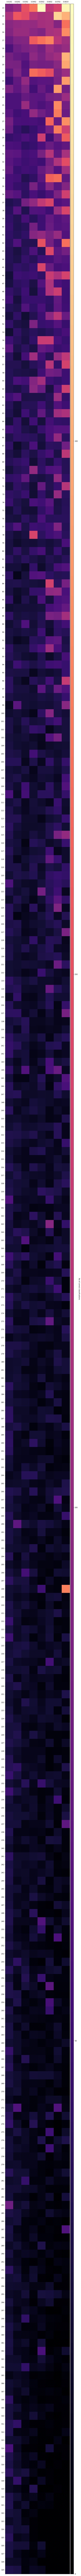

In [18]:
from mpl_toolkits.axes_grid1 import make_axes_locatable # Used to divide the main grid with the colour bar

fig, ax = plt.subplots() # create plots and set the figure width and height to 300 x 50
fig.set_figheight(300)
fig.set_figwidth(50)
im = ax.imshow(grid,cmap="magma") # create an image of the grid using the magma colour map


# Show all ticks and label them with the respective list entries
ax.set_yticks(np.arange(grid.shape[0]))
ax.set_yticklabels(np.arange(13,330))
ax.set_xticks(np.arange(grid.shape[1]))
ax.set_xticklabels(np.around(gammas,decimals=4)) # use round the gammas to make them more readable


# create a divider for the grid and the colourbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05) # create a an axis towards the right of the grid

cbar = plt.colorbar(im, cax=cax) # plot the color bar

cbar.ax.set_ylabel("No of correct classifications", rotation=-90, va="bottom") # add color bar labels
# Let the horizontal axes labeling appear on top.
ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)
plt.show() # show the plot